# Analysing Cafe Landscape in Toronto

## Introduction

**Business Problem** An aspiring coffee shop owner would like to open a small coffee shop in Toronto. As a new business owner, he would like to find the area where the competition is not too intense with many good coffee shop around. 

**Methodology** 
 - find a list of cafe in Toronto neighborhood
 - find the rating for each cafe
 - Based on how people rate cafe, cluster the neighborhoods to find areas that presents the best opportunities to open a cafe

**Data Collection**
 For this project, we are going to use: 
 - Canada Postal Code from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 - Use geocode to get latitude and longitude data
 - use Foursquare API to get venue data as well as rating data. 

## Import Library

In [ ]:
# Import necessary library

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import pylab as pl

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import map data
import folium # map rendering library

# import beautiful soup
from bs4 import BeautifulSoup as bsoup

## Extracting Postal Code Data

In [4]:
# Extract neighborhood data using beautiful soup

# Downloading the page using requests
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

#Parsing a page with BeautifulSoup
soup = bsoup(page.content, "html.parser")

# Extract table data
table = soup.find("table")
output_rows = []
for table_row in table.findAll('tr'):
    columns = table_row.findAll('td')
    output_row = []
    for column in columns:
        text = column.text
        text = text.replace('\n','')
        output_row.append(text)
    output_rows.append(output_row)
        
# Put the data in dataframe
import pandas as pd
df=pd.DataFrame(output_rows,columns=['Postcode','Borough', 'Neighborhood'])
df.drop(df.index[0], inplace = True)


In [5]:
# Data Cleaning

# drop rows with 'Not assigned' Borough
df = df[df.Borough != 'Not assigned']
df.reset_index(drop = True, inplace = True)

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
df.Neighborhood = df.Neighborhood.replace('Not assigned', df.Borough)

# Group neighborhoods with the same postcode
df_group = df.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df_group.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
# Add Geospatial Data
#read geospatial data 
geofile = pd.read_csv('Geospatial_Coordinates.csv')
geofile.rename(columns = {'Postal Code':'Postcode'}, inplace = True)


In [7]:
# # Merge the two datafile based on Postcode
df_merge = pd.merge(df_group, geofile, on='Postcode')
df_merge.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [8]:
# Filter data to only neighborhood in Toronto (only keep neighborhood in Borough with the word Toronto in them)
toronto_data = df_merge[df_merge['Borough'].str.contains('Toronto')].reset_index(drop =True)
toronto_data


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [22]:
# The code was removed by Watson Studio for sharing.

# Extract Coffee Shop in each Neighborhood

In [16]:
# Write a function to extract nearby venues in each neighborhood with a radius of 500 metres
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue_id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue_id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,4bd461bc77b29c74a07d9282,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,4ad4c062f964a52011f820e3,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,4b8daea1f964a520480833e3,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,4df91c4bae60f95f82229ad5,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,4bce4183ef10952197da8386,Pantheon,43.677621,-79.351434,Greek Restaurant


In [44]:
# Keep only venues that are coffee shops
cafe_df = toronto_venues[toronto_venues['Venue Category'].isin(['Café','Coffee Shop'])].reset_index(drop = True)
cafe_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue_id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"The Danforth West, Riverdale",43.679557,-79.352188,55fc0110498ecbc14aa76933,Marvel Coffee Co.,43.678630,-79.347460,Coffee Shop
1,"The Danforth West, Riverdale",43.679557,-79.352188,4af5de4ff964a5200cfe21e3,Second Cup,43.677188,-79.352975,Coffee Shop
2,"The Danforth West, Riverdale",43.679557,-79.352188,4b8d7b70f964a52063fe32e3,Cafe Frappe,43.678126,-79.348434,Coffee Shop
3,"The Danforth West, Riverdale",43.679557,-79.352188,4adcba1cf964a520272f21e3,Starbucks,43.678730,-79.346188,Coffee Shop
4,Studio District,43.659526,-79.340923,4ad78ecaf964a520220c21e3,Te Aro,43.661373,-79.338577,Coffee Shop
5,Studio District,43.659526,-79.340923,5475df76498eab68d4a3a6b9,Purple Penguin Cafe,43.660501,-79.342565,Café
6,Studio District,43.659526,-79.340923,4ae0c900f964a520718221e3,Mercury Espresso Bar,43.660806,-79.341241,Coffee Shop
7,Studio District,43.659526,-79.340923,4ade03e3f964a5205d6721e3,Starbucks,43.660640,-79.342461,Coffee Shop
8,Studio District,43.659526,-79.340923,55637f1c498ecfe4c5dd2322,Boxcar Social,43.659723,-79.346871,Café
9,Studio District,43.659526,-79.340923,57409b70498ed44f235dc2bc,Sweat & Soda,43.661854,-79.336196,Café


In [159]:
# The code was removed by Watson Studio for sharing.

In [160]:
cafe_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue_id,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,rating_class
0,"The Danforth West, Riverdale",43.679557,-79.352188,55fc0110498ecbc14aa76933,Marvel Coffee Co.,43.678630,-79.347460,Coffee Shop,7.7,Not Rated
1,"The Danforth West, Riverdale",43.679557,-79.352188,4af5de4ff964a5200cfe21e3,Second Cup,43.677188,-79.352975,Coffee Shop,7.1,Not Rated
2,"The Danforth West, Riverdale",43.679557,-79.352188,4b8d7b70f964a52063fe32e3,Cafe Frappe,43.678126,-79.348434,Coffee Shop,7.1,Not Rated
3,"The Danforth West, Riverdale",43.679557,-79.352188,4adcba1cf964a520272f21e3,Starbucks,43.678730,-79.346188,Coffee Shop,6.7,Not Rated
4,Studio District,43.659526,-79.340923,4ad78ecaf964a520220c21e3,Te Aro,43.661373,-79.338577,Coffee Shop,6,Not Rated
5,Studio District,43.659526,-79.340923,5475df76498eab68d4a3a6b9,Purple Penguin Cafe,43.660501,-79.342565,Café,8.7,Not Rated
6,Studio District,43.659526,-79.340923,4ae0c900f964a520718221e3,Mercury Espresso Bar,43.660806,-79.341241,Coffee Shop,7.9,Not Rated
7,Studio District,43.659526,-79.340923,4ade03e3f964a5205d6721e3,Starbucks,43.660640,-79.342461,Coffee Shop,7.6,Not Rated
8,Studio District,43.659526,-79.340923,55637f1c498ecfe4c5dd2322,Boxcar Social,43.659723,-79.346871,Café,7.3,Not Rated
9,Studio District,43.659526,-79.340923,57409b70498ed44f235dc2bc,Sweat & Soda,43.661854,-79.336196,Café,9,Not Rated


In [54]:
# Find out how many venues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(cafe_df.shape[0]))


232 venues were returned by Foursquare.


In [19]:
# Map the Coffee Shop

# generate a map of Coffee Shops in Toronto

latitude = 43.70011
longitude = -79.4163

cafe_toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add marker
for lat, lng, label in zip(cafe_df['Venue Latitude'], cafe_df['Venue Longitude'], cafe_df['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cafe_toronto_map) 
    
cafe_toronto_map


## Extract Coffee Shop Ratings

In [115]:
# Get the rating for each cafe

rating_list = []

for i in range(0, len(cafe_df['Venue_id'])):
    
    #url 
    
    venue_id = cafe_df['Venue_id'][i]
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)


    result = requests.get(url).json()
    try:
        rating = result['response']['venue']['rating']
    except:
        rating = 'NA'
    
    rating_list.append(rating)
    
cafe_df['rating'] = rating_list
    

In [182]:
# Bin the rating
# Categorize the rating into low (<6.5), medium (6.5-8.5), high (>8.5), and not rated ('NA')

rating_class = []

for i in range(0,len(cafe_df['rating'])):
    
    r = cafe_df['rating'][i]
    
    try: b = float(r)
    except: b = -1
        
    if b < 0.0: 
        rc = "Not Rated"
    elif b < 6.5:
        rc = "Low"
    elif b > 8:
        rc = "High"
    else: rc = "Medium"
    
    rating_class.append(rc)
    

cafe_df['rating_class'] = rating_class
cafe_df


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue_id,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,rating_class
0,"The Danforth West, Riverdale",43.679557,-79.352188,55fc0110498ecbc14aa76933,Marvel Coffee Co.,43.678630,-79.347460,Coffee Shop,7.7,Medium
1,"The Danforth West, Riverdale",43.679557,-79.352188,4af5de4ff964a5200cfe21e3,Second Cup,43.677188,-79.352975,Coffee Shop,7.1,Medium
2,"The Danforth West, Riverdale",43.679557,-79.352188,4b8d7b70f964a52063fe32e3,Cafe Frappe,43.678126,-79.348434,Coffee Shop,7.1,Medium
3,"The Danforth West, Riverdale",43.679557,-79.352188,4adcba1cf964a520272f21e3,Starbucks,43.678730,-79.346188,Coffee Shop,6.7,Medium
4,Studio District,43.659526,-79.340923,4ad78ecaf964a520220c21e3,Te Aro,43.661373,-79.338577,Coffee Shop,6,Low
5,Studio District,43.659526,-79.340923,5475df76498eab68d4a3a6b9,Purple Penguin Cafe,43.660501,-79.342565,Café,8.7,High
6,Studio District,43.659526,-79.340923,4ae0c900f964a520718221e3,Mercury Espresso Bar,43.660806,-79.341241,Coffee Shop,7.9,Medium
7,Studio District,43.659526,-79.340923,4ade03e3f964a5205d6721e3,Starbucks,43.660640,-79.342461,Coffee Shop,7.6,Medium
8,Studio District,43.659526,-79.340923,55637f1c498ecfe4c5dd2322,Boxcar Social,43.659723,-79.346871,Café,7.3,Medium
9,Studio District,43.659526,-79.340923,57409b70498ed44f235dc2bc,Sweat & Soda,43.661854,-79.336196,Café,9,High


In [183]:
# Distribution of Cafe by each neighborhood

cafe_onehot = pd.get_dummies(cafe_df[['rating_class']], prefix="", prefix_sep="")

# add neighborhood into the data set
cafe_onehot['Neighborhood'] = cafe_df['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [cafe_onehot.columns[-1]] + list(cafe_onehot.columns[:-1])
cafe_onehot = cafe_onehot[fixed_columns]

# Count the frequency of each rating_class in each neighborhood
cafe_grouped = cafe_onehot.groupby('Neighborhood').sum().reset_index()
cafe_grouped['Total Cafe'] = cafe_grouped.sum(axis = 1)

#Sort the Neighborhood by the number of Total Cafe
cafe_grouped.sort_values('Total Cafe', inplace = True, ascending = False)
cafe_grouped.reset_index(drop=True)


,Neighborhood,High,Low,Medium,Not Rated,Total Cafe
0,"Design Exchange, Toronto Dominion Centre",9,1,10,2,22
1,Central Bay Street,5,0,11,1,17
2,"First Canadian Place, Underground city",4,0,1,11,16
3,"Commerce Court, Victoria Hotel",4,0,0,12,16
4,"Harbourfront East, Toronto Islands, Union Station",4,0,11,0,15
5,Stn A PO Boxes 25 The Esplanade,3,1,3,7,14
6,St. James Town,8,0,5,0,13
7,"Ryerson, Garden District",2,0,9,1,12
8,"Adelaide, King, Richmond",7,3,2,0,12
9,"Chinatown, Grange Park, Kensington Market",3,1,0,6,10


## Cluster Analysis

In [184]:
# Cluster the neighborhood based on the number of high, low, medium rated cafe
cafe_grouped_clustering = cafe_grouped.drop('Neighborhood',1).reset_index(drop= True)
cafe_grouped_clustering

,High,Low,Medium,Not Rated,Total Cafe
0,9,1,10,2,22
1,5,0,11,1,17
2,4,0,1,11,16
3,4,0,0,12,16
4,4,0,11,0,15
5,3,1,3,7,14
6,8,0,5,0,13
7,2,0,9,1,12
8,7,3,2,0,12
9,3,1,0,6,10


In [185]:
# Since the owner is concerned about competitng with cafe with already high rating. 
# We give more weight to number of highly rated cafe when we cluster our neighborhood with high cafe rating
cafe_grouped_clustering['High'] = [x*2 for x in cafe_grouped_clustering['High']]
cafe_grouped_clustering

,High,Low,Medium,Not Rated,Total Cafe
0,18,1,10,2,22
1,10,0,11,1,17
2,8,0,1,11,16
3,8,0,0,12,16
4,8,0,11,0,15
5,6,1,3,7,14
6,16,0,5,0,13
7,4,0,9,1,12
8,14,3,2,0,12
9,6,1,0,6,10


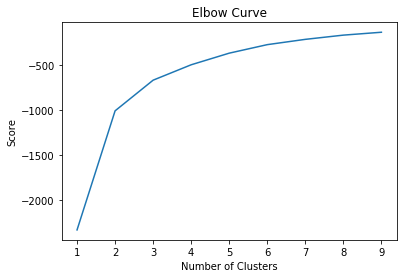

In [186]:
# Find the optimal K

Nc = range(1, 10)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(cafe_grouped_clustering).score(cafe_grouped_clustering) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [ ]:
# From the graph, we see that k = 3 is optimal

In [187]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cafe_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [188]:

# add clustering labels
cafe_grouped['Cluster Labels'] = kmeans.labels_

cafe_grouped.head()


,Neighborhood,High,Low,Medium,Not Rated,Total Cafe,Cluster Labels
12,"Design Exchange, Toronto Dominion Centre",9,1,10,2,22,1
5,Central Bay Street,5,0,11,1,17,1
14,"First Canadian Place, Underground city",4,0,1,11,16,2
9,"Commerce Court, Victoria Hotel",4,0,0,12,16,2
16,"Harbourfront East, Toronto Islands, Union Station",4,0,11,0,15,1


In [193]:
# Examine Cluster

# Cluster 1

cluster1 = cafe_grouped[cafe_grouped['Cluster Labels'] == 2]
cluster1

,Neighborhood,High,Low,Medium,Not Rated,Total Cafe,Cluster Labels
14,"First Canadian Place, Underground city",4,0,1,11,16,2
9,"Commerce Court, Victoria Hotel",4,0,0,12,16,2
25,Stn A PO Boxes 25 The Esplanade,3,1,3,7,14,2
6,"Chinatown, Grange Park, Kensington Market",3,1,0,6,10,2


Cluster 1 is a collection of neighborhoods with unexplored coffee shop. There are plenty of coffee shops, the majority of which are not rated which mean they might not be visited by a lot of people. As such, the owner may want to avoid this neighborhood as coffee shop here tend to not get high traffic rate. 

In [190]:
# Cluster 2

cluster2 = cafe_grouped[cafe_grouped['Cluster Labels'] == 1]
cluster2

,Neighborhood,High,Low,Medium,Not Rated,Total Cafe,Cluster Labels
12,"Design Exchange, Toronto Dominion Centre",9,1,10,2,22,1
5,Central Bay Street,5,0,11,1,17,1
16,"Harbourfront East, Toronto Islands, Union Station",4,0,11,0,15,1
24,St. James Town,8,0,5,0,13,1
23,"Ryerson, Garden District",2,0,9,1,12,1
0,"Adelaide, King, Richmond",7,3,2,0,12,1
17,"Harbourfront, Regent Park",7,1,2,0,10,1


In [194]:
# Cluster 3

cluster3 = cafe_grouped[cafe_grouped['Cluster Labels'] == 0]
cluster3

,Neighborhood,High,Low,Medium,Not Rated,Total Cafe,Cluster Labels
8,Church and Wellesley,2,2,4,1,9,0
26,Studio District,2,1,4,0,7,0
27,"The Annex, North Midtown, Yorkville",2,1,0,3,6,0
22,"Runnymede, Swansea",0,0,0,6,6,0
19,"Little Portugal, Trinity",0,0,2,4,6,0
1,Berczy Park,3,0,3,0,6,0
15,"Harbord, University of Toronto",0,1,2,2,5,0
4,"Cabbagetown, St. James Town",1,2,2,0,5,0
10,Davisville,1,2,1,0,4,0
2,"Brockton, Exhibition Place, Parkdale Village",1,0,0,3,4,0


Cluster 4 presents a lot of opportunities for the owner as there are not many coffee shops around. There are also not many highly rated coffee shops in the areas which make it easier for the owner to compete for market share.

# Cluster Neighborhood

In [195]:
cafe_grouped['latitude'] = cafe_df['Neighborhood Latitude']
cafe_grouped['longitude'] = cafe_df['Neighborhood Longitude']
cafe_grouped

,Neighborhood,High,Low,Medium,Not Rated,Total Cafe,Cluster Labels,latitude,longitude
12,"Design Exchange, Toronto Dominion Centre",9,1,10,2,22,1,43.715383,-79.405678
5,Central Bay Street,5,0,11,1,17,1,43.659526,-79.340923
14,"First Canadian Place, Underground city",4,0,1,11,16,2,43.704324,-79.388790
9,"Commerce Court, Victoria Hotel",4,0,0,12,16,2,43.659526,-79.340923
16,"Harbourfront East, Toronto Islands, Union Station",4,0,11,0,15,1,43.704324,-79.388790
25,Stn A PO Boxes 25 The Esplanade,3,1,3,7,14,2,43.665860,-79.383160
24,St. James Town,8,0,5,0,13,1,43.665860,-79.383160
23,"Ryerson, Garden District",2,0,9,1,12,1,43.667967,-79.367675
0,"Adelaide, King, Richmond",7,3,2,0,12,1,43.679557,-79.352188
6,"Chinatown, Grange Park, Kensington Market",3,1,0,6,10,2,43.659526,-79.340923


In [196]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**10 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cafe_grouped['latitude'], cafe_grouped['longitude'], cafe_grouped['Neighborhood'], cafe_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Further analysis could be done to cluster 3 such as collecting demogrpahic data, traffic etc. 